In [160]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

In [62]:
path = "../data/investing.com/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith(("LB", "JN", "LL", "LN", "LT", "LX")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True, thousands=",")
        df = df.iloc[:, 0:1].astype(float)
        if (df <= 0).any().any():
            print(f"Non-positive values found in {file[:-4]}")
        df = df[df > 0]

        # reverse the rows
        df = df.iloc[::-1]
        # drop the first row and last 2 rows to match cc1 data
        df = df.iloc[0:-4]

        print(file[:-4], df.shape)

BO (155, 1)
CC (155, 1)
CL (155, 1)
CO (155, 1)
CT (150, 1)
C_ (155, 1)
DA (150, 1)
FC (155, 1)
GC (155, 1)
HG (155, 1)
HO (155, 1)
JO (155, 1)
KC (155, 1)
LA (120, 1)
LC (155, 1)
LH (155, 1)
NG (155, 1)
O_ (155, 1)
PA (155, 1)
PL (155, 1)
QS (155, 1)
RR (155, 1)
RS (155, 1)
SB (155, 1)
SI (155, 1)
SM (155, 1)
S_ (155, 1)
W_ (155, 1)
XB (149, 1)


CT, DA could only find data starting from 2011/12/01  
LA from 2014/06/01  
XB from 2012/01/01  
Therefore, we take all of the data starting from 2011/12/01, and exclude LA and XB.

In [188]:
df_dict_cc1 = {}
valid_dates = pd.date_range(start="2011-01-01", end="2024-12-31", freq="B")
# Read each file in below folder
path = "../data/raw/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LA, LB, JN, LL, LN, LT, LX, XB due to data correctness issue
        if file.startswith(("LA", "LB", "JN", "LL", "LN", "LT", "LX", "XB")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)

        # Drop non-positive values in price and volatility
        non_positive_LA = df[(df[df.columns[0]] <= 0) | (df['Volatility'] <= 0)]
        if not non_positive_LA.empty:
            print(f"Non-positive values found in {file[:-4]}")
        df = df.drop(index=non_positive_LA.index)

        df_dict_cc1[file[:-4]] = df
        valid_dates = valid_dates.intersection(df.index)

for name, df in df_dict_cc1.items():
    df = df[df.index.isin(valid_dates)].loc["2011-12-30":"2024-05-31"]
    df_dict_cc1[name] = df

In [239]:
df_dict_cc2 = {}
# Read each file in below folder
path = "../data/investing.com/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith(("LA", "LB", "JN", "LL", "LN", "LT", "LX", "XB")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True, thousands=",")
        df = df.iloc[:, 0:1].astype(float)
        if (df <= 0).any().any():
            print(f"Non-positive values found in {file[:-4]}")
        df = df[df > 0]

        # reverse the rows
        df = df.iloc[::-1]
        # take data during 2012-01-01 to 2024-05-01 only
        df = df.loc["2012-01-01":"2024-05-01"]

        # HG, HO
        if file.startswith(("HG", "HO")):
            df = df * 100
        # save the data
        df.to_csv(f"../data/processed/{file[:-4]}.csv")

        df_dict_cc2[file[:-4]] = df

### Calculate the Return for Holding CC2 for one month

In [240]:
for name, df in df_dict_cc1.items():
    numerator = df.iloc[:, 0:1].shift(-1)[:-1]
    denominator = df_dict_cc2[name].iloc[:, 0:1]
    df["Return"] = np.append(np.log(numerator.values / denominator.values), np.nan)

In [241]:
dates_len = df_dict_cc1["BO"].shape[0]
train_size = 3 * 12
test_size = 1

start_end_list = []
start = 0
while(start < dates_len - train_size - test_size):
    end = start + train_size + test_size - 1
    start_end_list.append((start, end))
    start = start + test_size

# print(start_end_list)

### Regression and Prediction

### OLS

In [242]:
ols_mse_by_time = []
for start, end in start_end_list:
    ols_mse_by_df = []
    for name, df in df_dict_cc1.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test_X, test_y = df.iloc[end - test_size + 1:end - test_size + 2].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end - test_size + 2]["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        ols = LinearRegression()
        ols.fit(train_X, train_y)
        ols_predict = ols.predict(test_X)
        # print(name, df.index[end - test_size], ols_predict)
        ols_mse = mean_squared_error(test_y, ols_predict)
        ols_mse_by_df.append(ols_mse)

    ols_mse_by_time.append(np.mean(ols_mse_by_df))

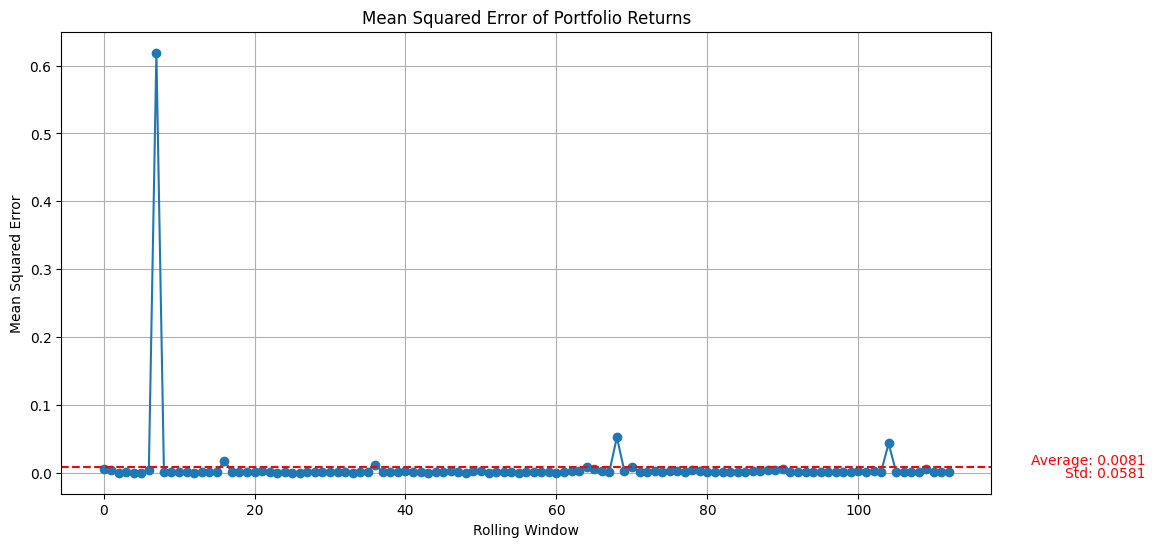

In [243]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(ols_mse_by_time, marker='o')
plt.axhline(y=np.mean(ols_mse_by_time), color='r', linestyle='--')
plt.text(len(ols_mse_by_time) + 25, np.mean(ols_mse_by_time), f"Average: {np.mean(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(ols_mse_by_time) + 25, np.mean(ols_mse_by_time) - 0.02, f"Std: {np.std(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Stein

In [244]:
stein_mse_by_time = []
for start, end in start_end_list:
    stein_mse_by_df = []
    for name, df in df_dict_cc1.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test_X, test_y = df.iloc[end - test_size + 1:end - test_size + 2].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end - test_size + 2]["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        model_mult = SavvySh(model_class="Multiplicative")
        model_mult.fit(train_X, train_y)
        stein_predict = model_mult.predict(test_X)["St"]
        # print(name, df.index[end - test_size], stein_predict)
        stein_mse = mean_squared_error(test_y, stein_predict)
        stein_mse_by_df.append(stein_mse)

    stein_mse_by_time.append(np.mean(stein_mse_by_df))

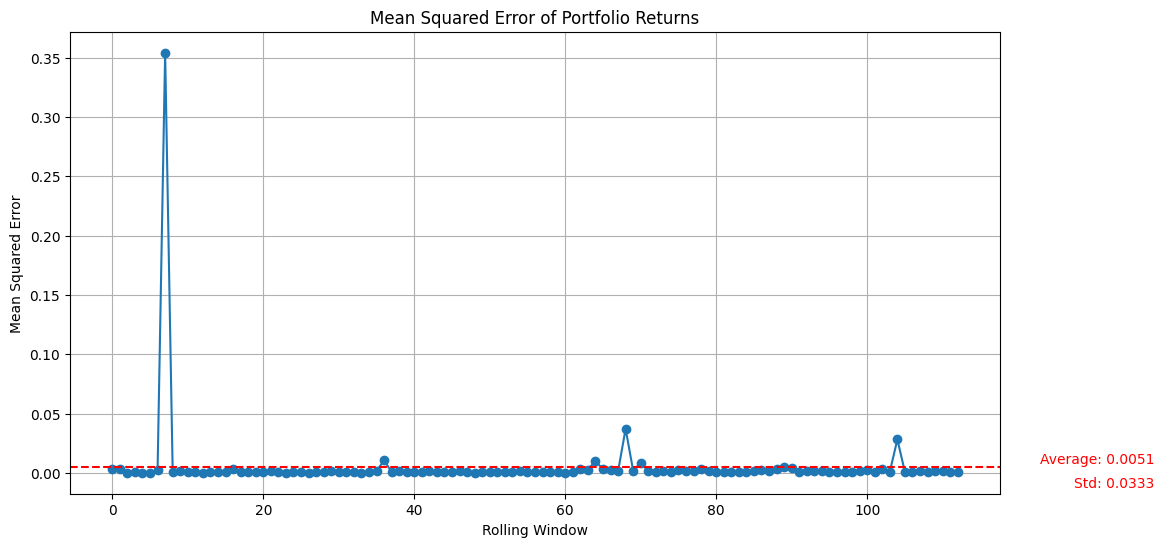

In [245]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(stein_mse_by_time, marker='o')
plt.axhline(y=np.mean(stein_mse_by_time), color='r', linestyle='--')
plt.text(len(stein_mse_by_time) + 25, np.mean(stein_mse_by_time), f"Average: {np.mean(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(stein_mse_by_time) + 25, np.mean(stein_mse_by_time) - 0.02, f"Std: {np.std(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### DSh

In [246]:
DSh_mse_by_time = []
for start, end in start_end_list:
    DSh_mse_by_df = []
    for name, df in df_dict_cc1.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test = df.iloc[end - test_size + 1:end - test_size + 2]
        test_X, test_y = test.drop(columns=["Basis_Momentum", "Return"]), test["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        model_mult = SavvySh(model_class="Multiplicative")
        model_mult.fit(train_X, train_y)
        DSh_predict = model_mult.predict(test_X)["DSh"]
        # print(name, df.index[end - test_size], DSh_predict)
        DSh_mse = mean_squared_error(test_y, DSh_predict)
        DSh_mse_by_df.append(DSh_mse)

    DSh_mse_by_time.append(np.mean(DSh_mse_by_df))

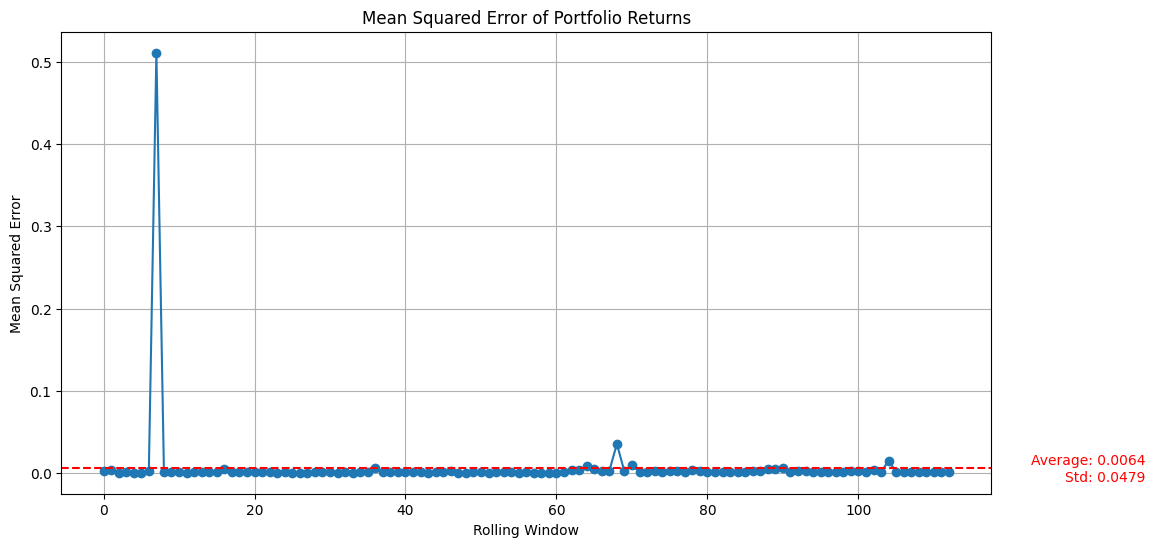

In [247]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(DSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(DSh_mse_by_time), color='r', linestyle='--')
plt.text(len(DSh_mse_by_time) + 25, np.mean(DSh_mse_by_time), f"Average: {np.mean(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(DSh_mse_by_time) + 25, np.mean(DSh_mse_by_time) - 0.02, f"Std: {np.std(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Portfolio weighted by returns

In [ ]:
threshold = 0.005
indexs = df_dict_cc1["BO"].index

In [301]:
# Initialize
strategies = ["OLS", "Stein", "DSh"]
weights_dict = {}
wealth_dict = {}
initial_capital = 10000
returns_dict = {strat: [] for strat in strategies}

for strat in strategies:
    weights_dict[strat] = pd.DataFrame(columns=list(df_dict_cc1.keys()) + ["Wealth"], index=pd.Index([], name="Time"))
    wealth_dict[strat] = [initial_capital]

# Main loop
for start, end in start_end_list:
    for strat in strategies:
        temp_long_return = 0
        temp_short_return = 0
        long_weights = 0
        short_weights = 0

        temp_weights = pd.Series(0.0, index=list(df_dict_cc1.keys()))

        for name, df in df_dict_cc1.items():
            train = df.iloc[start:end - test_size + 1]
            train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
            next_index = end - test_size + 1
            if next_index + 1 >= len(df):
                continue
            test_X = df.iloc[[next_index]].drop(columns=["Basis_Momentum", "Return"])

            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

            # Prediction
            if strat == "OLS":
                model = LinearRegression()
                model.fit(train_X, train_y)
                predict = model.predict(test_X).flatten()[0]
            else:
                model_mult = SavvySh(model_class="Multiplicative")
                model_mult.fit(train_X, train_y)
                tmp_pred = model_mult.predict(test_X)
                if strat == "Stein":
                    predict = tmp_pred["St"][0]
                elif strat == "DSh":
                    predict = tmp_pred["DSh"][0]

            # Calculate long / short return
            price_t = df_dict_cc2[name].iloc[next_index, 0]
            price_t1 = df_dict_cc1[name].iloc[next_index + 1, 0]

            if predict > threshold:
                long_weights += predict
                temp_long_return += predict * (price_t1 / price_t - 1)
                temp_weights[name] = predict
            elif predict < -threshold:
                short_weights -= predict  # Take negative as weights
                temp_short_return += -predict * (1 - price_t1 / price_t)
                temp_weights[name] = predict

        # Normalize weights to avoid division by zero
        if long_weights > 0:
            temp_weights[temp_weights > 0] = 0.5 * temp_weights[temp_weights > 0] / long_weights
        if short_weights > 0:
            temp_weights[temp_weights < 0] = 0.5 * (-temp_weights[temp_weights < 0]) / short_weights * -1
        weights_dict[strat].loc[indexs[next_index]] = temp_weights

        # Calculate portfolio return
        portfolio_return = 0
        if long_weights > 0:
            portfolio_return += 0.5 * temp_long_return / long_weights
        if short_weights > 0:
            portfolio_return += 0.5 * temp_short_return / short_weights

        # Update wealth
        wealth_dict[strat].append(wealth_dict[strat][-1] * (1 + portfolio_return))
        returns_dict[strat].append(portfolio_return)
        weights_dict[strat].loc[indexs[next_index], "Wealth"] = wealth_dict[strat][-1]

In [306]:
sharpe_ratio_dict = {}

for strat in strategies:
    returns = np.array(returns_dict[strat])
    sharpe_ratio = np.mean(returns) / np.std(returns, ddof=1)
    annualized_sharpe = sharpe_ratio * np.sqrt(12)
    sharpe_ratio_dict[strat] = annualized_sharpe

print(sharpe_ratio_dict)

{'OLS': 2.8522659720148984, 'Stein': 2.734907450075587, 'DSh': 3.075195532096916}
